In [29]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('eth.csv')
print(df)

      Unnamed: 0 formatted_date         high          low         open  \
0              0     2019-01-01   141.397507   132.650711   141.519516   
1              1     2019-01-02   156.929138   140.650955   155.196045   
2              2     2019-01-03   155.863052   147.198364   148.912888   
3              3     2019-01-04   156.878983   147.907104   154.337418   
4              4     2019-01-05   160.824890   154.337418   155.804230   
...          ...            ...          ...          ...          ...   
1515        1515     2023-02-24  1661.091309  1583.147827  1608.658325   
1516        1516     2023-02-25  1608.865112  1567.631714  1594.761108   
1517        1517     2023-02-26  1645.273438  1590.393066  1640.763672   
1518        1518     2023-02-27  1662.575684  1615.387939  1634.502441   
1519        1519     2023-02-28  1644.435791  1602.428101  1606.040405   

            close      volume     adjclose  
0      140.819412  2258709868   140.819412  
1      155.047684  33

In [31]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['close'].rolling(window=ma_3).std()
df.dropna(inplace=True)
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,119.715439,116.157440,117.110756,117.157852,2421720343,117.157852,3.557999,121.640524,127.196642,135.496240,2.635404,15.088666
21,21,2019-01-22,119.664345,114.676682,118.713814,118.747551,2552507405,118.747551,4.987663,121.171215,124.938636,134.445199,2.838598,15.463410
22,22,2019-01-23,119.422798,116.376648,117.462784,117.452606,2556952198,117.452606,3.046150,120.300577,122.556456,132.654957,2.921848,15.131627
23,23,2019-01-24,118.032104,116.006798,117.594955,117.362885,2520843420,117.362885,2.025307,119.389287,121.752007,131.141999,2.651955,14.989176
24,24,2019-01-25,117.802994,115.830154,116.373528,116.378342,2606881898,116.378342,1.972839,118.727584,120.954151,129.322780,2.755917,14.304793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,1661.091309,1583.147827,1608.658325,1608.373169,8909129423,1608.373169,77.943481,1662.377982,1626.017447,1622.058291,32.361529,64.912140
1516,1516,2023-02-25,1608.865112,1567.631714,1594.761108,1594.914917,5657686235,1594.914917,41.233398,1648.534476,1629.945173,1618.622849,37.917844,64.317786
1517,1517,2023-02-26,1645.273438,1590.393066,1640.763672,1640.817139,5727967432,1640.817139,54.880371,1642.731759,1638.929705,1619.059576,35.042625,64.441653
1518,1518,2023-02-27,1662.575684,1615.387939,1634.502441,1634.326416,7239824677,1634.326416,47.187744,1632.967651,1648.012599,1619.920497,23.014437,64.522916


In [32]:
pre_day = 7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

300
(1193, 7, 9) (1193, 1) (300, 7, 9) (300, 1)


In [33]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_close.h5")

Epoch 1/120
40/40 [==============================] - 18s 18ms/step - loss: 0.0164
Epoch 2/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0046
Epoch 3/120
40/40 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 4/120
40/40 [==============================] - 1s 18ms/step - loss: 0.0038
Epoch 5/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0036
Epoch 6/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0037
Epoch 7/120
40/40 [==============================] - 1s 18ms/step - loss: 0.0036
Epoch 8/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0033
Epoch 9/120
40/40 [==============================] - 1s 18ms/step - loss: 0.0032
Epoch 10/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 11/120
40/40 [==============================] - 1s 18ms/step - loss: 0.0026
Epoch 12/120
40/40 [==============================] - 1s 22ms/step - loss: 0.0029
Epoch 13/120
40/40 [====

In [34]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

38/38 [==============================] - 6s 8ms/step
      predict_price  y_train_price  error_price
0        133.947510     106.589973    27.357536
1        127.053932     105.598213    21.455719
2        121.223511     108.907539    12.315971
3        120.921944     107.061012    13.860931
4        121.405334     107.609787    13.795547
...             ...            ...          ...
1188    2929.874268    2730.186768   199.687500
1189    2846.430908    2827.756104    18.674805
1190    2879.263916    2857.410400    21.853516
1191    2919.322998    2783.476318   135.846680
1192    2879.283203    2940.644775   -61.361572

[1193 rows x 3 columns]


In [35]:

from sklearn.linear_model import ElasticNet
import pickle
elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [36]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_close.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [37]:
predict_price = model.predict(x_test)
print(predict_price)

10/10 [==============================] - 0s 8ms/step
[[0.60710484]
 [0.59123755]
 [0.5695973 ]
 [0.5568497 ]
 [0.53633004]
 [0.48740947]
 [0.48617733]
 [0.45438504]
 [0.41257566]
 [0.4257334 ]
 [0.4325109 ]
 [0.45137125]
 [0.4345262 ]
 [0.44133943]
 [0.41340122]
 [0.4165691 ]
 [0.4149502 ]
 [0.41412956]
 [0.42692167]
 [0.4207958 ]
 [0.41157198]
 [0.40658268]
 [0.37558708]
 [0.34958625]
 [0.35077083]
 [0.3613721 ]
 [0.3913713 ]
 [0.39180523]
 [0.37210798]
 [0.3628484 ]
 [0.3589117 ]
 [0.3623828 ]
 [0.36565736]
 [0.3797735 ]
 [0.37151814]
 [0.3654019 ]
 [0.36560482]
 [0.34598437]
 [0.31500953]
 [0.29189587]
 [0.25332844]
 [0.23833327]
 [0.2443114 ]
 [0.2379992 ]
 [0.23342437]
 [0.22254649]
 [0.24314854]
 [0.24534464]
 [0.24836521]
 [0.23779114]
 [0.2442625 ]
 [0.2595029 ]
 [0.26278996]
 [0.2570682 ]
 [0.24940167]
 [0.23986289]
 [0.2261788 ]
 [0.20983134]
 [0.20387474]
 [0.20104769]
 [0.20178196]
 [0.21489143]
 [0.21766576]
 [0.22393867]
 [0.23420867]
 [0.23865348]
 [0.23780191]
 [0.23288

In [38]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[2967.9006]
 [2893.2046]
 [2791.3318]
 [2731.3215]
 [2634.7239]
 [2404.427 ]
 [2398.6267]
 [2248.9624]
 [2052.142 ]
 [2114.0828]
 [2145.9885]
 [2234.775 ]
 [2155.4758]
 [2187.5493]
 [2056.0286]
 [2070.9417]
 [2063.3203]
 [2059.4573]
 [2119.6768]
 [2090.8389]
 [2047.4171]
 [2023.9298]
 [1878.016 ]
 [1755.6154]
 [1761.1919]
 [1811.098 ]
 [1952.3212]
 [1954.3639]
 [1861.6378]
 [1818.0477]
 [1799.5155]
 [1815.856 ]
 [1831.2712]
 [1897.7238]
 [1858.8611]
 [1830.0686]
 [1831.0238]
 [1738.6593]
 [1592.8433]
 [1484.0342]
 [1302.4755]
 [1231.8849]
 [1260.0275]
 [1230.3121]
 [1208.7758]
 [1157.5675]
 [1254.553 ]
 [1264.8914]
 [1279.1108]
 [1229.3328]
 [1259.7972]
 [1331.5421]
 [1347.0162]
 [1320.0807]
 [1283.9901]
 [1239.0856]
 [1174.667 ]
 [1097.7102]
 [1069.6691]
 [1056.3606]
 [1059.8173]
 [1121.531 ]
 [1134.5913]
 [1164.1213]
 [1212.468 ]
 [1233.3922]
 [1229.3834]
 [1206.2241]
 [1133.9813]
 [1053.8542]
 [1076.5968]
 [1160.4563]
 [1230.9065]
 [1317.4788]
 [1340.1428]
 [1499.7957]
 [1568.1396]

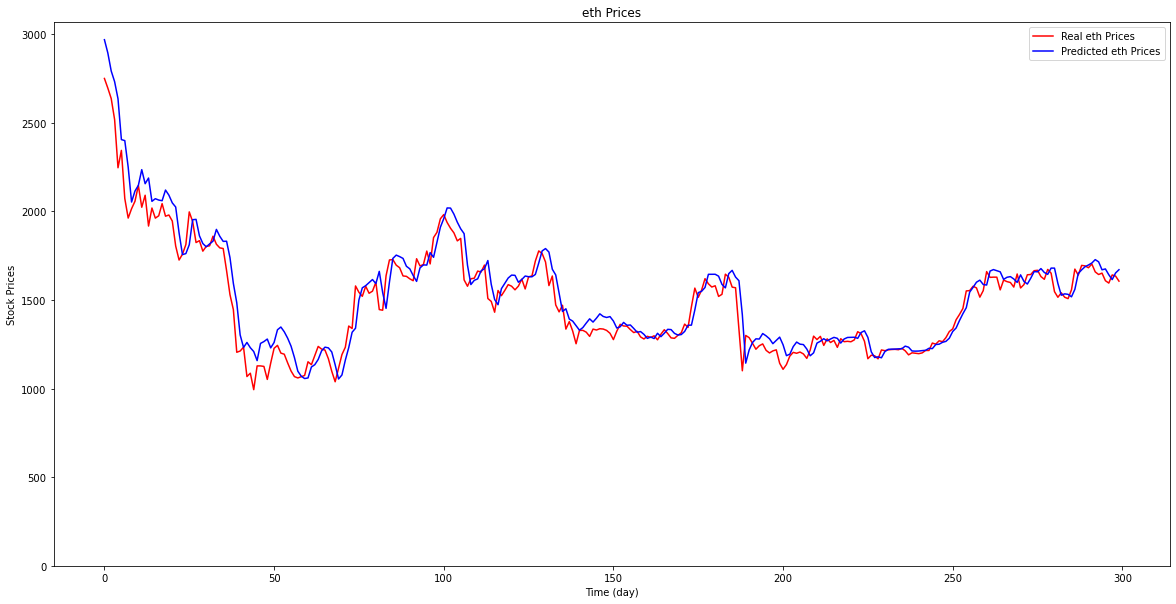

In [39]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real eth Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted eth Prices")
plt.title(f"eth Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [40]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 65.61
MAPE: 4.44%
MSE: 8615.02
RMSE: 92.82
R2: 0.90


In [41]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [42]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))